In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import os
import warnings
import sys
warnings.filterwarnings("ignore")
# sys.path.append("../") # local root
PROJECT_PATH = '/content/drive/MyDrive/likelion/smartphone_defect_segmentation'
sys.path.append(PROJECT_PATH)

from dotenv import load_dotenv
from src.segtool.config import DataConfig, TrainConfig
from src.segtool.data import (
    make_loaders,
    DefectSegDataset,
    DatasetPaths,
    default_paths,
    find_mask
)
from src.segtool.model import UNet
from src.segtool.models_factory import build_model
from src.segtool.losses import BCEDiceLoss, DiceLoss
from src.segtool.engine import (
    train_one_epoch,
    validate,
    EpochResult,
    _defect_only_metrics
)
from src.segtool.metrics import compute_metrics, reduce_mean, Metrics
from src.segtool.utils import *

In [3]:
load_dotenv()
set_seed(42)
device = get_device()
wandb_api_key = os.getenv("WANDB_API_KEY")
print(device)
print(wandb_api_key)

cuda
None


In [4]:
!nvidia-smi

Wed Jan  7 02:24:52 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 실험1

- scratch class 제외 모든 class에 augmentation 적용
- 하지만 augmentation 된 image에는 기존 class의 mask 유지 (ex: 기존 [0, 38])

In [5]:
# Colab root
dataset_root = "/content/drive/MyDrive/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect"
# # Local root
# dataset_root = "/Users/mungughyeon/Library/CloudStorage/GoogleDrive-moonstalker9010@gmail.com/내 드라이브/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect"

base_path = Path(dataset_root)
train_loader, val_loader, test_loader = make_loaders(
    base_path=base_path,
    img_size_hw=(288, 512),  # (height, width)
    train_ratio=0.7,
    test_ratio=0.15,
    seed=42,
    batch_size=16,
    num_workers=2
)

print(f"Train: {len(train_loader.dataset)}")
print(f"Val: {len(val_loader.dataset)}")
print(f"Test: {len(test_loader.dataset)}")

Train: 1026
Val: 221
Test: 219


In [6]:
unet_aug_1 = UNet(
    in_channels=3,
    out_channels=1,
    base_channels=32,
    # dropout=0.1
).to(device)

total_params = sum(p.numel() for p in unet_aug_1.parameters())
trainable_params = sum(p.numel() for p in unet_aug_1.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 466,529
Trainable parameters: 466,529


In [7]:
# optimizer
optimizer = torch.optim.Adam(
    unet.parameters(),
    lr=1e-3,
    weight_decay=0.0
)

# loss function
criterion = BCEDiceLoss(bce_weight=0.5)  # BCE와 Dice Loss 조합

print(f"Device: {device}")
print(f"Model: {unet.__class__.__name__}")
print(f"Loss function: {criterion.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
# print(f"Dropout: {getattr(unet.dropout, 'p', 0.0)}")

Device: cuda
Model: UNet
Loss function: BCEDiceLoss
Optimizer: Adam
Batch size: 16
Learning rate: 0.001


In [8]:
epochs = 30
best_val_dice = -1.0
threshold = 0.5

# wandb
wandb_config = {
    "model": unet.__class__.__name__,
    "epochs": epochs,
    "threshold": threshold,
    "batch_size": train_loader.batch_size,
    "learning_rate": optimizer.param_groups[0]['lr'],
    "weight_decay": optimizer.param_groups[0]['weight_decay'],
    "loss": criterion.__class__.__name__,
    "optimizer": optimizer.__class__.__name__,
    # "dropout": getattr(unet.dropout, 'p', 0.0),
    "device": str(device),
}

# wandb init
wandb.init(
    project="mobile-phone-defect",
    name=f"{unet.__class__.__name__}_Aug_1",
    config=wandb_config
)

train_losses = []
val_losses = []
train_dices = []
val_dices = []
val_defect_dices = []

epochs = 30
best_val_dice = -1.0
threshold = 0.5

print(f"Starting Training for {epochs} epochs")
print("=" * 60)

# loop
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    # Training
    train_result = train_one_epoch(
        model=unet,
        loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    # Validation
    val_result = validate(
        model=unet,
        loader=val_loader,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    # 기록 저장
    train_losses.append(train_result.loss)
    val_losses.append(val_result.loss)
    train_dices.append(train_result.metrics_all.dice)
    val_dices.append(val_result.metrics_all.dice)
    val_defect_dices.append(val_result.metrics_defect_only.dice)

    # wandb 로깅
    wandb.log({
        "epoch": epoch,
        "train/loss": train_result.loss,
        "train/dice_all": train_result.metrics_all.dice,
        "train/iou_all": train_result.metrics_all.iou,
        "val/loss": val_result.loss,
        "val/dice_all": val_result.metrics_all.dice,
        "val/iou_all": val_result.metrics_all.iou,
        "val/dice_defect": val_result.metrics_defect_only.dice,
        "val/iou_defect": val_result.metrics_defect_only.iou,
        "val/precision_defect": val_result.metrics_defect_only.precision,
        "val/recall_defect": val_result.metrics_defect_only.recall,
    })

    # result
    print(f"Train - Loss: {train_result.loss:.4f} | Dice: {train_result.metrics_all.dice:.4f}")
    print(f"Val - Loss: {val_result.loss:.4f} | Dice: {val_result.metrics_all.dice:.4f} | Defect Dice: {val_result.metrics_defect_only.dice:.4f}")
    print("-" * 60)

    if val_result.metrics_defect_only.dice > best_val_dice:
        best_val_dice = val_result.metrics_defect_only.dice
        # 최고 성능 기록
        wandb.run.summary["best_val_defect_dice"] = best_val_dice

print("\nTraining completed!")
print(f"Best Validation Defect Dice: {best_val_dice:.4f}")

# 실험 종료
wandb.finish()

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: moonstalker9010 (moonstalker9010-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting Training for 30 epochs
Epoch 1/30
Train - Loss: 0.5678 | Dice: 0.0010
Val - Loss: 0.5201 | Dice: 0.0000 | Defect Dice: 0.0000
------------------------------------------------------------
Epoch 2/30
Train - Loss: 0.4820 | Dice: 0.0603
Val - Loss: 0.3607 | Dice: 0.4876 | Defect Dice: 0.5295
------------------------------------------------------------
Epoch 3/30
Train - Loss: 0.2480 | Dice: 0.5757
Val - Loss: 0.2437 | Dice: 0.5897 | Defect Dice: 0.6057
------------------------------------------------------------
Epoch 4/30
Train - Loss: 0.1867 | Dice: 0.6772
Val - Loss: 0.2134 | Dice: 0.6406 | Defect Dice: 0.6542
------------------------------------------------------------
Epoch 5/30
Train - Loss: 0.1767 | Dice: 0.6932
Val - Loss: 0.1711 | Dice: 0.7128 | Defect Dice: 0.7349
------------------------------------------------------------
Epoch 6/30
Train - Loss: 0.1313 | Dice: 0.7724
Val - Loss: 0.1330 | Dice: 0.7776 | Defect Dice: 0.7984
---------------------------------------------

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/dice_all,▁▁▆▆▆▇▇▇▇█▇▇██████████████████
train/iou_all,▁▁▅▅▆▆▆▇▇▇▇▇▇█▇███████████████
train/loss,█▇▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/dice_all,▁▅▆▆▇▇▇▇███████████████████▇▇█
val/dice_defect,▁▅▆▆▇▇▇▇██████████████████████
val/iou_all,▁▄▅▅▆▇▆▇▇▇███████▇█████▇███▇▇▇
val/iou_defect,▁▄▅▆▆▇▆▇▇▇████▇████████████▇▇█
val/loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
val/precision_defect,█▁▄▅▄▅▂▃▄▆▅▄▅▇▃▆▄▄▄▅▆▄▆▃▄▅▅▂▃▃
+1,...


In [9]:
def plot_training_history(train_losses, val_losses, train_dices, val_dices, val_defect_dices,
                        save_path=None, figsize=(16, 6)):
    plt.figure(figsize=figsize)
    epochs = range(1, len(train_losses) + 1)
    best_val_dice = max(val_defect_dices)
    best_epoch = val_defect_dices.index(best_val_dice) + 1

    # 1. Loss curves
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Dice Score curves (All samples)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_dices, 'b-', label='Train Dice', linewidth=2)
    plt.plot(epochs, val_dices, 'r-', label='Val Dice', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Dice Score (All Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Defect-only Dice Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_defect_dices, 'g-', label='Val Dice (Defect)', linewidth=2)
    plt.axhline(y=best_val_dice, color='orange', linestyle='--',
                label=f'Best: {best_val_dice:.4f}')
    plt.axvline(x=best_epoch, color='orange', linestyle=':', alpha=0.7,
                label=f'Best Epoch: {best_epoch}')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Defect-Only Dice Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    plt.show()

    # Print summary
    print_training_summary(train_losses, val_losses, val_dices, val_defect_dices)

def print_training_summary(train_losses, val_losses, val_dices, val_defect_dices):
    """Print training summary statistics"""
    best_val_dice = max(val_defect_dices)
    best_epoch = val_defect_dices.index(best_val_dice) + 1

    print(f"TRAINING SUMMARY")
    print(f"{'='*50}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Final Val Loss: {val_losses[-1]:.4f}")
    print(f"Final Val Dice (All): {val_dices[-1]:.4f}")
    print(f"Final Val Dice (Defect): {val_defect_dices[-1]:.4f}")
    print(f"Best Val Dice (Defect): {best_val_dice:.4f}")
    print(f"Best Epoch: {best_epoch}")

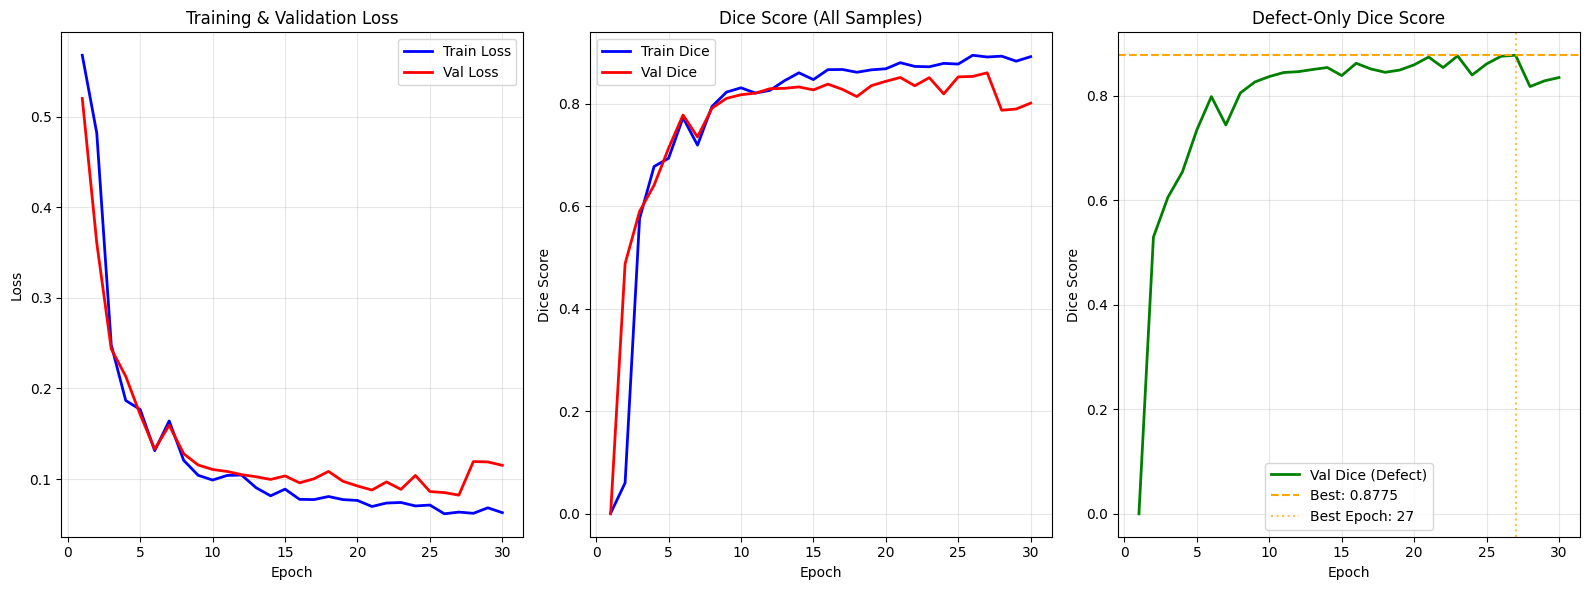

TRAINING SUMMARY
Final Train Loss: 0.0629
Final Val Loss: 0.1152
Final Val Dice (All): 0.8008
Final Val Dice (Defect): 0.8348
Best Val Dice (Defect): 0.8775
Best Epoch: 27


In [10]:
plot_training_history(
    train_losses,
    val_losses,
    train_dices,
    val_dices,
    val_defect_dices
)

In [15]:
def inference_test_set(model, test_loader, criterion, device, threshold=0.5):
    """Inference model on test set"""
    test_result = validate(
        model=model,
        loader=test_loader,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    print("TEST RESULTS")
    print("=" * 40)
    print(f"Test Loss: {test_result.loss:.4f}")
    print(f"Test Dice (All): {test_result.metrics_all.dice:.4f}")
    print(f"Test IoU (All): {test_result.metrics_all.iou:.4f}")
    print(f"Test Precision (All): {test_result.metrics_all.precision:.4f}")
    print(f"Test Recall (All): {test_result.metrics_all.recall:.4f}")
    print()
    print("DEFECT-ONLY METRICS")
    print("-" * 30)
    print(f"Test Dice (Defects): {test_result.metrics_defect_only.dice:.4f}")
    print(f"Test IoU (Defects): {test_result.metrics_defect_only.iou:.4f}")
    print(f"Test Precision (Defects): {test_result.metrics_defect_only.precision:.4f}")
    print(f"Test Recall (Defects): {test_result.metrics_defect_only.recall:.4f}")

    return test_result

def inference_visualize(model, test_loader, device, threshold=0.5, num_samples=8):
    """Model inference and visualization"""
    model.eval()

    # Get random samples from test set
    samples = []
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if len(samples) >= num_samples:
                break

            # Unpack 4 items: (images, masks, class_names, file_names)
            images, masks = batch[0], batch[1]
            images = images.to(device)
            masks = masks.to(device)

            # Model prediction
            outputs = model(images)
            preds = torch.sigmoid(outputs) > threshold

            # Convert to numpy for visualization
            for j in range(images.size(0)):
                if len(samples) >= num_samples:
                    break

                img = images[j].cpu().permute(1, 2, 0).numpy()
                true_mask = masks[j].cpu().squeeze().numpy()
                pred_mask = preds[j].cpu().squeeze().numpy()
                prob_map = torch.sigmoid(outputs[j]).cpu().squeeze().numpy()

                samples.append({
                    'image': img,
                    'true_mask': true_mask,
                    'pred_mask': pred_mask,
                    'prob_map': prob_map
                })

    # Visualization
    fig, axes = plt.subplots(4, num_samples, figsize=(3*num_samples, 12))

    for i, sample in enumerate(samples):
        # Original image
        axes[0, i].imshow(sample['image'])
        axes[0, i].set_title(f'Sample {i+1}')
        axes[0, i].axis('off')

        # Ground truth mask
        axes[1, i].imshow(sample['true_mask'], cmap='gray')
        axes[1, i].set_title('Ground Truth')
        axes[1, i].axis('off')

        # Prediction probability map
        axes[2, i].imshow(sample['prob_map'], cmap='hot', vmin=0, vmax=1)
        axes[2, i].set_title('Probability Map')
        axes[2, i].axis('off')

        # Binary prediction
        axes[3, i].imshow(sample['pred_mask'], cmap='gray')
        axes[3, i].set_title(f'Prediction (>{threshold})')
        axes[3, i].axis('off')

    plt.tight_layout()
    plt.show()

    return samples

TEST RESULTS
Test Loss: 0.0818
Test Dice (All): 0.8576
Test IoU (All): 0.7557
Test Precision (All): 0.8632
Test Recall (All): 0.8604

DEFECT-ONLY METRICS
------------------------------
Test Dice (Defects): 0.8286
Test IoU (Defects): 0.7397
Test Precision (Defects): 0.8009
Test Recall (Defects): 0.9042


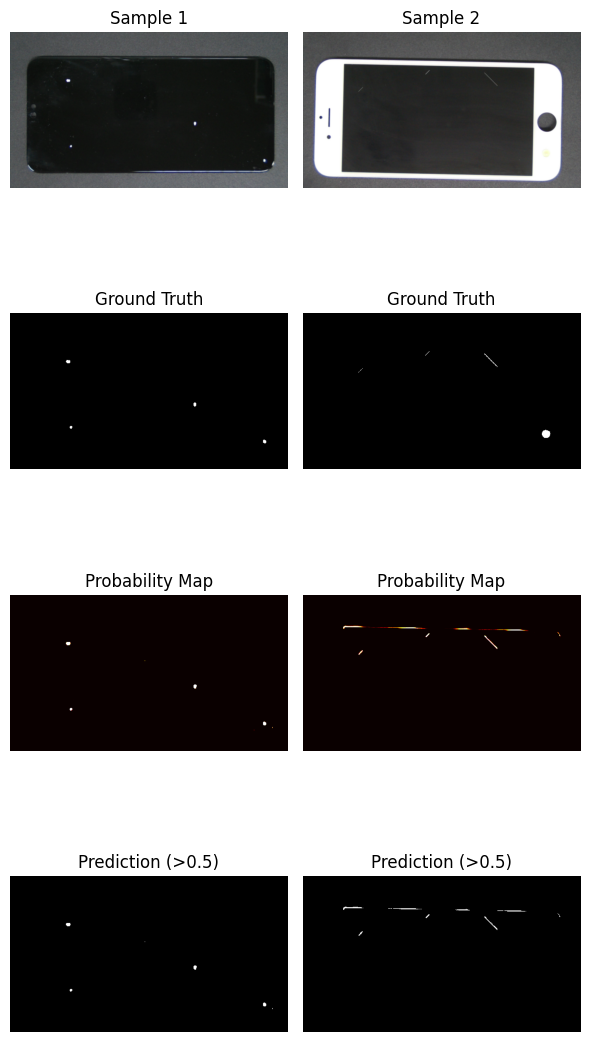

In [12]:
test_result = inference_test_set(unet, test_loader, criterion, device, threshold=0.5)
samples = inference_visualize(unet, test_loader, device, threshold=0.5, num_samples=2)

### Test case Inference

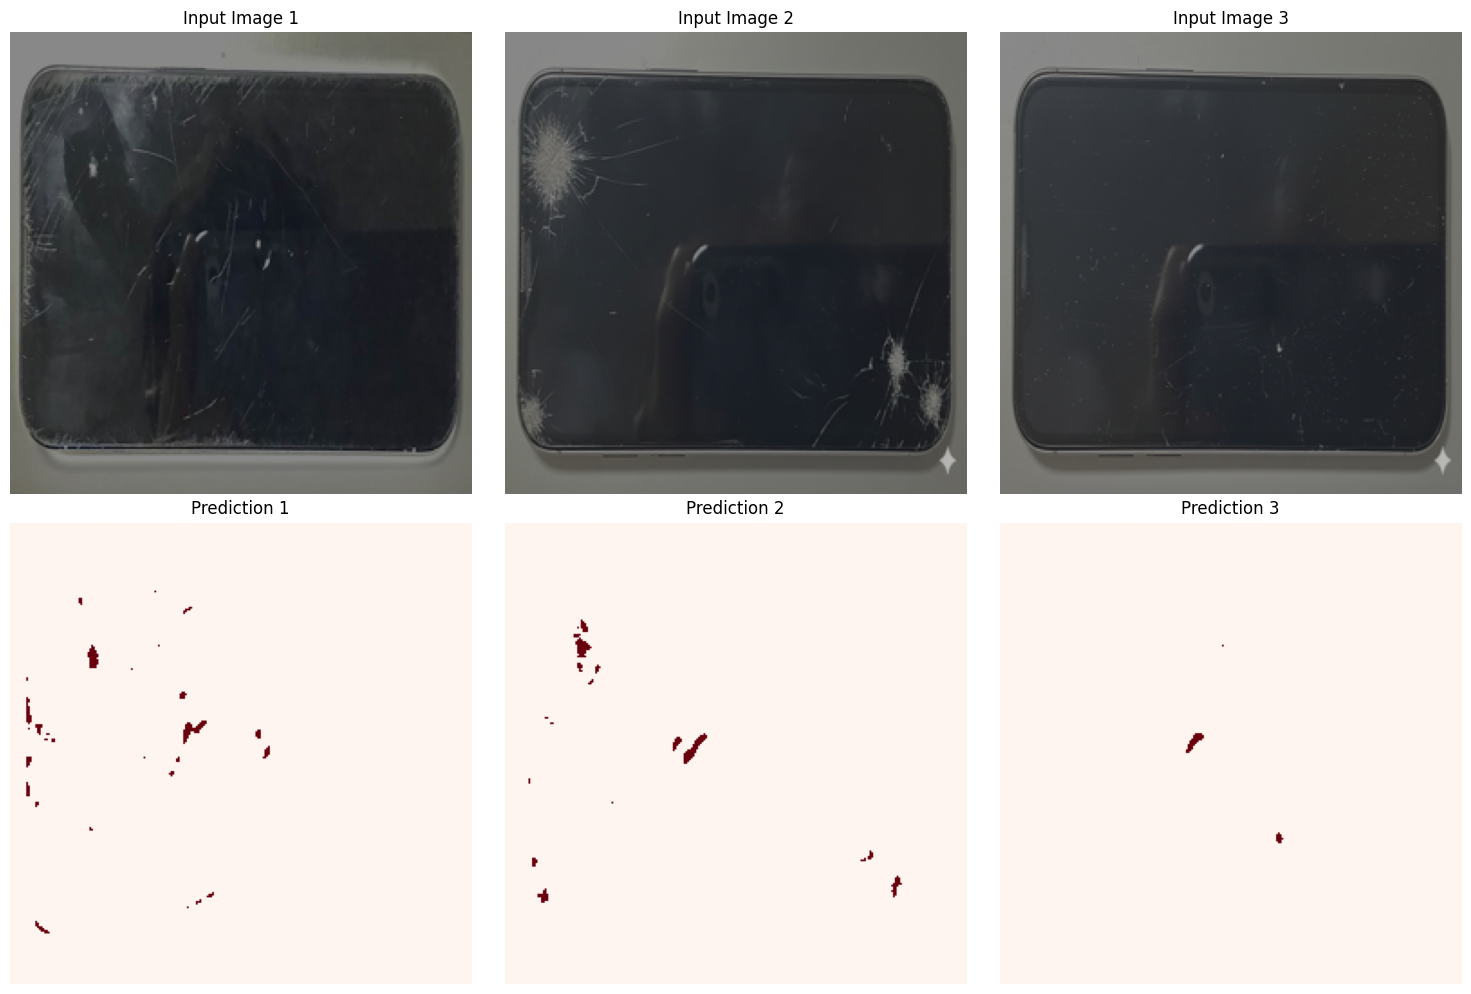

In [20]:
from PIL import Image
import glob

sample_test = f"{PROJECT_PATH}/data/Mobile Phone Defect/real"
img_files = glob.glob(f"{sample_test}/*.jpeg") + glob.glob(f"{sample_test}/*.png") + glob.glob(f"{sample_test}/*.jpg")

# 모든 이미지에 대해 처리
num_images = len(img_files)
fig, axes = plt.subplots(2, num_images, figsize=(5*num_images, 10))

# 이미지가 1개인 경우 axes 차원 조정
if num_images == 1:
    axes = axes.reshape(-1, 1)

for i, img_path in enumerate(img_files):
    # 이미지 로드
    img = Image.open(img_path).convert('RGB').resize((256, 256))
    img_array = np.array(img)

    # 예측
    img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.sigmoid(unet_aug_1(img_tensor)).cpu().numpy()[0, 0]
        pred_binary = (pred > 0.5).astype(np.uint8)

    # 시각화
    axes[0, i].imshow(img_array)
    axes[0, i].set_title(f'Input Image {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(pred_binary, cmap='Reds')
    axes[1, i].set_title(f'Prediction {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

---

In [27]:
model_save_path = f"{PROJECT_PATH}/models"
os.makedirs(model_save_path, exist_ok=True)

torch.save(unet.state_dict(), f"{model_save_path}/unet_aug_model_1.pth")
print(f"Model save: {model_save_path}/unet_aug_model_1.pth")

Model save: /content/drive/MyDrive/likelion/smartphone_defect_segmentation/models/unet_aug_model.pth


### 실험2

- 실제 잔기스를 더 잘 잡기 위한 augmentation 실험
- good class에만 augmentation 적용
- 이번엔 별도로 label 진행 (class가 5개가 되는거임)

In [4]:
# Colab root
dataset_root = "/content/drive/MyDrive/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect"
# # Local root
# dataset_root = "/Users/mungughyeon/Library/CloudStorage/GoogleDrive-moonstalker9010@gmail.com/내 드라이브/likelion/smartphone_defect_segmentation/data/Mobile Phone Defect"

base_path = Path(dataset_root)
train_loader, val_loader, test_loader = make_loaders(
    base_path=base_path,
    img_size_hw=(288, 512),  # (height, width)
    train_ratio=0.7,
    test_ratio=0.15,
    seed=42,
    batch_size=16,
    num_workers=2
)

print(f"Train: {len(train_loader.dataset)}")
print(f"Val: {len(val_loader.dataset)}")
print(f"Test: {len(test_loader.dataset)}")

Train: 1134
Val: 243
Test: 243


In [5]:
unet_aug_2 = UNet(
    in_channels=3,
    out_channels=1,
    base_channels=32,
    # dropout=0.1
).to(device)

total_params = sum(p.numel() for p in unet_aug_2.parameters())
trainable_params = sum(p.numel() for p in unet_aug_2.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 466,529
Trainable parameters: 466,529


In [6]:
# optimizer
optimizer = torch.optim.Adam(
    unet.parameters(),
    lr=1e-3,
    weight_decay=0.0
)

# loss function
criterion = BCEDiceLoss(bce_weight=0.5)  # BCE와 Dice Loss 조합

print(f"Device: {device}")
print(f"Model: {unet.__class__.__name__}")
print(f"Loss function: {criterion.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
# print(f"Dropout: {getattr(unet.dropout, 'p', 0.0)}")

Device: cuda
Model: UNet
Loss function: BCEDiceLoss
Optimizer: Adam
Batch size: 16
Learning rate: 0.001


In [7]:
epochs = 30
best_val_dice = -1.0
threshold = 0.5

# wandb
wandb_config = {
    "model": unet.__class__.__name__,
    "epochs": epochs,
    "threshold": threshold,
    "batch_size": train_loader.batch_size,
    "learning_rate": optimizer.param_groups[0]['lr'],
    "weight_decay": optimizer.param_groups[0]['weight_decay'],
    "loss": criterion.__class__.__name__,
    "optimizer": optimizer.__class__.__name__,
    # "dropout": getattr(unet.dropout, 'p', 0.0),
    "device": str(device),
}

# wandb init
wandb.init(
    project="mobile-phone-defect",
    name=f"{unet.__class__.__name__}_Aug_2",
    config=wandb_config
)

train_losses = []
val_losses = []
train_dices = []
val_dices = []
val_defect_dices = []

epochs = 30
best_val_dice = -1.0
threshold = 0.5

print(f"Starting Training for {epochs} epochs")
print("=" * 60)

# loop
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    # Training
    train_result = train_one_epoch(
        model=unet,
        loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    # Validation
    val_result = validate(
        model=unet,
        loader=val_loader,
        criterion=criterion,
        device=device,
        threshold=threshold
    )

    # 기록 저장
    train_losses.append(train_result.loss)
    val_losses.append(val_result.loss)
    train_dices.append(train_result.metrics_all.dice)
    val_dices.append(val_result.metrics_all.dice)
    val_defect_dices.append(val_result.metrics_defect_only.dice)

    # wandb 로깅
    wandb.log({
        "epoch": epoch,
        "train/loss": train_result.loss,
        "train/dice_all": train_result.metrics_all.dice,
        "train/iou_all": train_result.metrics_all.iou,
        "val/loss": val_result.loss,
        "val/dice_all": val_result.metrics_all.dice,
        "val/iou_all": val_result.metrics_all.iou,
        "val/dice_defect": val_result.metrics_defect_only.dice,
        "val/iou_defect": val_result.metrics_defect_only.iou,
        "val/precision_defect": val_result.metrics_defect_only.precision,
        "val/recall_defect": val_result.metrics_defect_only.recall,
    })

    # result
    print(f"Train - Loss: {train_result.loss:.4f} | Dice: {train_result.metrics_all.dice:.4f}")
    print(f"Val - Loss: {val_result.loss:.4f} | Dice: {val_result.metrics_all.dice:.4f} | Defect Dice: {val_result.metrics_defect_only.dice:.4f}")
    print("-" * 60)

    if val_result.metrics_defect_only.dice > best_val_dice:
        best_val_dice = val_result.metrics_defect_only.dice
        # 최고 성능 기록
        wandb.run.summary["best_val_defect_dice"] = best_val_dice

print("\nTraining completed!")
print(f"Best Validation Defect Dice: {best_val_dice:.4f}")

# 실험 종료
wandb.finish()

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: moonstalker9010 (moonstalker9010-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting Training for 30 epochs
Epoch 1/30
Train - Loss: 0.5629 | Dice: 0.0007
Val - Loss: 0.5147 | Dice: 0.0000 | Defect Dice: 0.0000
------------------------------------------------------------
Epoch 2/30
Train - Loss: 0.4894 | Dice: 0.0323
Val - Loss: 0.3776 | Dice: 0.3715 | Defect Dice: 0.3826
------------------------------------------------------------
Epoch 3/30
Train - Loss: 0.2881 | Dice: 0.5185
Val - Loss: 0.3003 | Dice: 0.4381 | Defect Dice: 0.4491
------------------------------------------------------------
Epoch 4/30
Train - Loss: 0.2048 | Dice: 0.6367
Val - Loss: 0.2617 | Dice: 0.5264 | Defect Dice: 0.5339
------------------------------------------------------------
Epoch 5/30
Train - Loss: 0.1837 | Dice: 0.6744
Val - Loss: 0.2508 | Dice: 0.5294 | Defect Dice: 0.5354
------------------------------------------------------------
Epoch 6/30
Train - Loss: 0.1488 | Dice: 0.7368
Val - Loss: 0.2349 | Dice: 0.5589 | Defect Dice: 0.5599
---------------------------------------------

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/dice_all,▁▁▅▆▆▇▇▇▇▇▇██▇▇▇██████████████
train/iou_all,▁▁▄▅▆▆▆▇▇▇▇▇▇▆▇▇▇████▇████████
train/loss,█▇▄▃▃▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/dice_all,▁▄▅▆▆▆▅▆▆▇▆▇▅▆▆▆▇▆▇▇▇▇▇██▇████
val/dice_defect,▁▄▅▆▆▆▆▆▆▇▇▇▅▆▇▇▇▇▇▇▇▇▇██▇████
val/iou_all,▁▄▄▅▅▆▅▆▆▇▆▇▅▆▆▆▇▆▇▇▇▇▇▇█▇▇███
val/iou_defect,▁▄▄▅▅▆▅▆▆▇▇▇▅▆▇▇▇▆▇▇▇▇▇██▇▇███
val/loss,█▆▄▄▄▃▄▃▃▂▃▂▄▃▃▂▂▃▂▂▂▂▂▁▁▂▁▁▁▁
val/precision_defect,█▆▁▃▃▃▂▆▆▆▆▅▃▆▆▆▆▃▆▆▅▅▅▆▇▆▆▆▆▆
+1,...


TEST RESULTS
Test Loss: 0.0682
Test Dice (All): 0.8764
Test IoU (All): 0.7903
Test Precision (All): 0.9185
Test Recall (All): 0.8450

DEFECT-ONLY METRICS
------------------------------
Test Dice (Defects): 0.8049
Test IoU (Defects): 0.7123
Test Precision (Defects): 0.8404
Test Recall (Defects): 0.8052


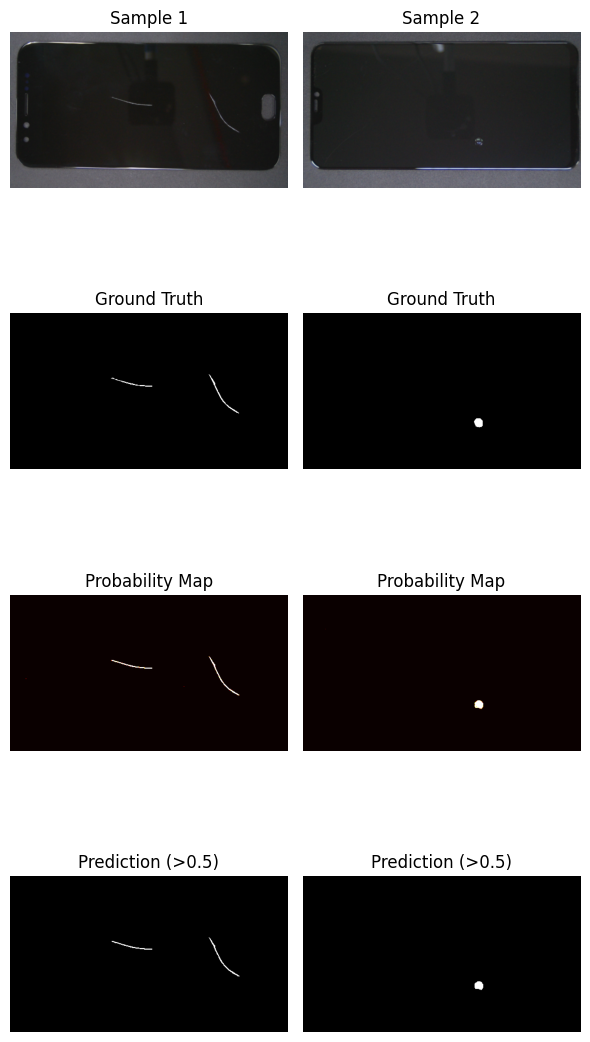

In [10]:
test_result = inference_test_set(unet, test_loader, criterion, device, threshold=0.5)
samples = inference_visualize(unet, test_loader, device, threshold=0.5, num_samples=2)

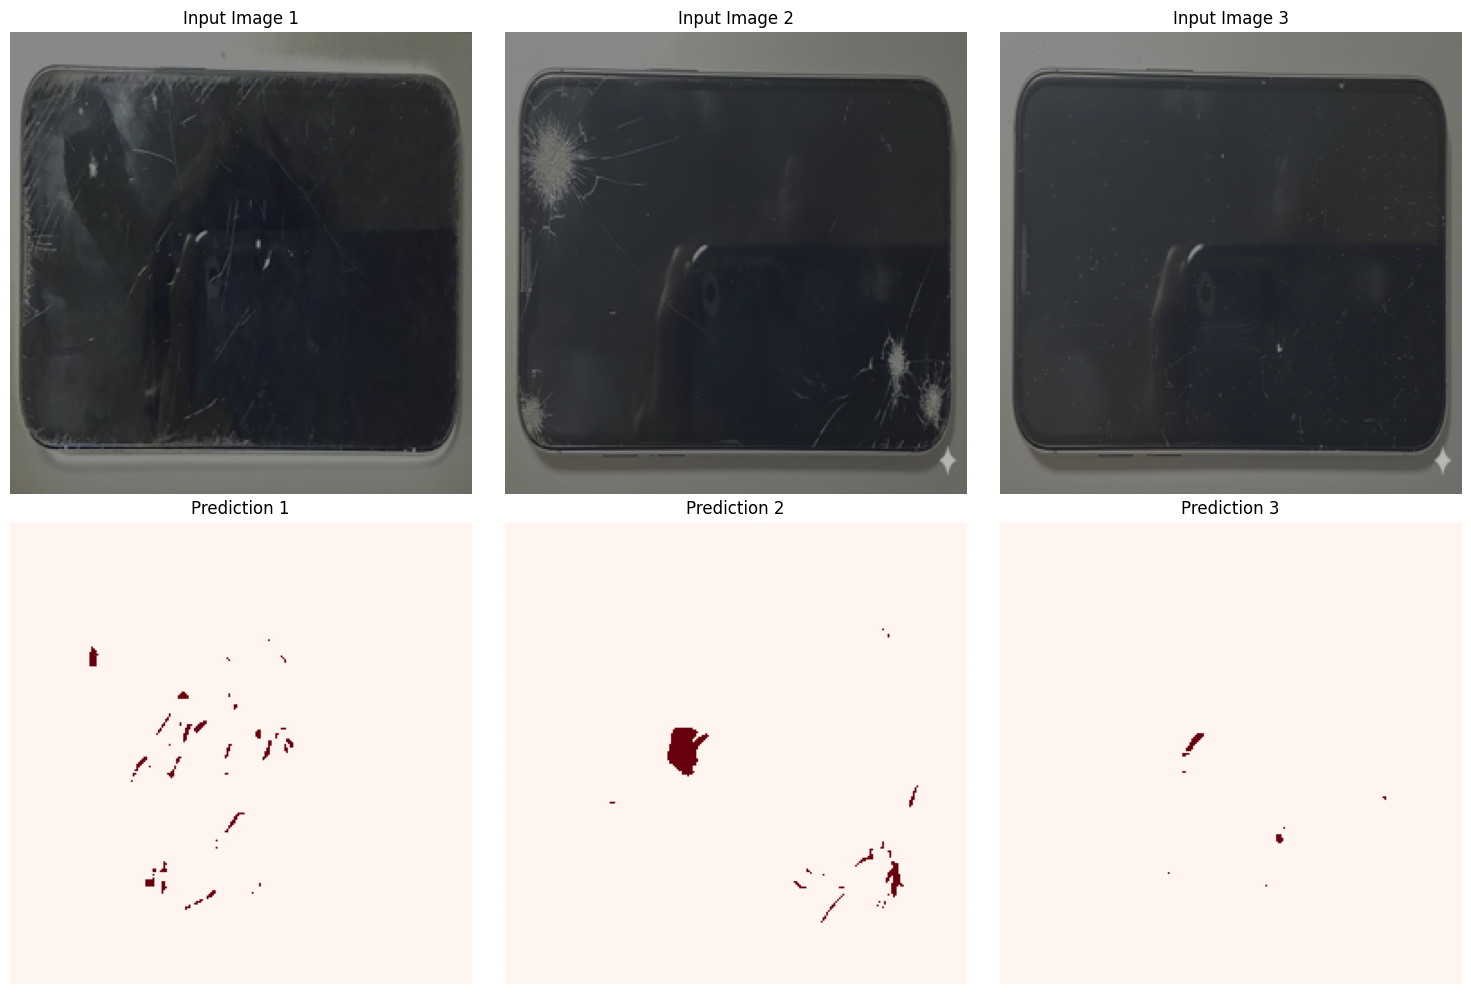

In [22]:
from PIL import Image
import glob

sample_test = f"{PROJECT_PATH}/data/Mobile Phone Defect/real"
img_files = glob.glob(f"{sample_test}/*.jpeg") + glob.glob(f"{sample_test}/*.png") + glob.glob(f"{sample_test}/*.jpg")

# 모든 이미지에 대해 처리
num_images = len(img_files)
fig, axes = plt.subplots(2, num_images, figsize=(5*num_images, 10))

# 이미지가 1개인 경우 axes 차원 조정
if num_images == 1:
    axes = axes.reshape(-1, 1)

for i, img_path in enumerate(img_files):
    # 이미지 로드
    img = Image.open(img_path).convert('RGB').resize((256, 256))
    img_array = np.array(img)

    # 예측
    img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.sigmoid(unet_aug_2(img_tensor)).cpu().numpy()[0, 0]
        pred_binary = (pred > 0.5).astype(np.uint8)

    # 시각화
    axes[0, i].imshow(img_array)
    axes[0, i].set_title(f'Input Image {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(pred_binary, cmap='Reds')
    axes[1, i].set_title(f'Prediction {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [18]:
model_save_path = f"{PROJECT_PATH}/models"
os.makedirs(model_save_path, exist_ok=True)

torch.save(unet.state_dict(), f"{model_save_path}/unet_aug_model_2.pth")
print(f"Model save: {model_save_path}/unet_aug_model_2.pth")

Model save: /content/drive/MyDrive/likelion/smartphone_defect_segmentation/models/unet_aug_model_2.pth
